In [1]:
%matplotlib inline

import io, os, sys, types, datetime, pickle, warnings

import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

import numpy as np

warnings.filterwarnings('ignore')

In [2]:
master_path = os.getcwd()
if master_path not in sys.path:
    sys.path.append(master_path)

In [3]:
def parse_folder_info(path):
    folders = [f for f in os.listdir(path) if not os.path.isfile(os.path.join(path, f))]
    files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
    if('.DS_Store' in files):
        files.remove('.DS_Store')
    if('._.DS_Store' in files):
        files.remove('._.DS_Store')
    return folders, files

In [4]:
def get_time_columns(columns):
    time_str = []
    time_datetime = []
    for col in columns:
        if col[0].isnumeric():
            time_str.append(col)
            time_datetime.append(datetime.datetime.strptime(col, '%m/%d/%y'))
    return time_str, time_datetime

In [5]:
def format_fn(tick_val, tick_pos):
    if(tick_val >= 0 and tick_val < len(time_str)):
        return time_str[int(tick_val)]
    else:
        return int(tick_val)

In [6]:
cat_color = {'Confirmed':'tab:blue', 'Deaths':'tab:orange', 'Recovered':'tab:green'}

In [7]:
path_time_series = os.path.join(master_path, 'csse_covid_19_data', 'csse_covid_19_time_series')

In [8]:
folders, files = parse_folder_info(path_time_series)
df_time_series = pd.DataFrame()
# df_time_series_reorged = pd.DataFrame(columns = ['Country/Region', 'Province/State', 'Date', 'Category', 'Number'])
for file_name in files:
    if('.csv' in file_name):
        df_current = pd.read_csv(os.path.join(path_time_series, file_name))        
        category = file_name[21:file_name.index('.csv')]
        print(category)
        df_current.loc[:,'Category'] = category
        if df_time_series.empty:
            df_time_series = df_current
        else:
            df_time_series = df_time_series.append(df_current, ignore_index = True)

time_str, time_datetime = get_time_columns(df_time_series.columns)
# pd.to_datetime()

Recovered
Deaths
Confirmed


In [9]:
df_time_series.loc[:,'New Today'] = df_time_series.loc[:,time_str[-1]] - df_time_series.loc[:,time_str[-2]]

In [10]:
""" Total Recovered, death, and confirmed """

' Total Recovered, death, and confirmed '

In [11]:
total = df_time_series.groupby('Category').sum().loc[:,time_str]
mainland_china = df_time_series.groupby('Country/Region').get_group('Mainland China').groupby('Category').sum().loc[:,time_str]
others = total - mainland_china

Text(0.5, 1.0, 'Total')

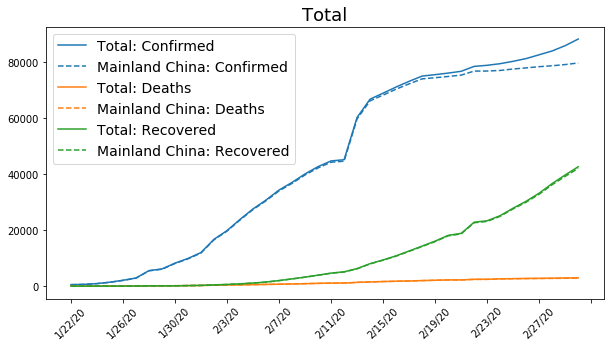

In [12]:
fig, ax1 = plt.subplots(1,1,figsize = (10,5))
for cat in cat_color:
    ax1.plot(total.groupby('Category').get_group(cat).sum()[time_str], color = cat_color[cat])
    ax1.plot(mainland_china.groupby('Category').get_group(cat).sum()[time_str], '--', color = cat_color[cat])
legend = ['Total: Confirmed',
         'Mainland China: Confirmed',
         'Total: Deaths',
         'Mainland China: Deaths',
         'Total: Recovered',
         'Mainland China: Recovered',]
myLocator = mticker.MultipleLocator(4)
ax1.xaxis.set_major_locator(myLocator)
ax1.tick_params(axis = 'x', labelrotation = 45)
ax1.legend(legend, fontsize = 14)
ax1.set_title('Total', size = 18)

Text(0.5, 1.0, 'Daily Cases')

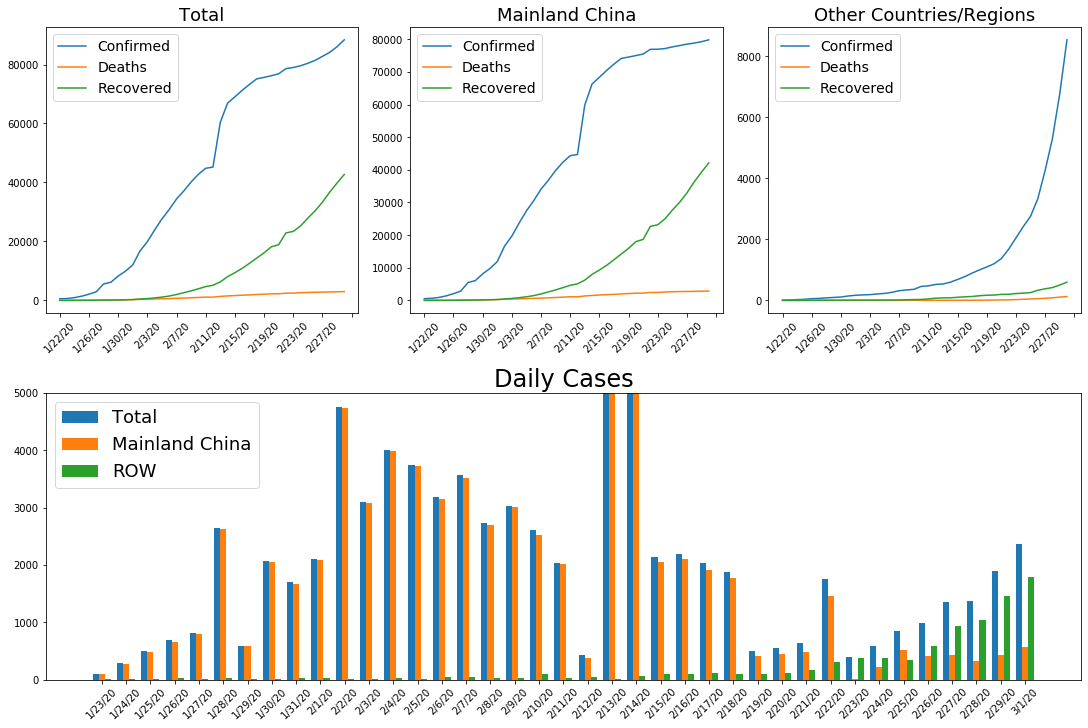

In [13]:
fig = plt.figure(figsize = (15, 10), constrained_layout=True)
gs = fig.add_gridspec(2,3)

ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(total.transpose())
myLocator = mticker.MultipleLocator(4)
ax1.xaxis.set_major_locator(myLocator)
ax1.tick_params(axis = 'x', labelrotation = 45)
ax1.legend(total.index, fontsize = 14)
ax1.set_title('Total', size = 18)

ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(mainland_china.transpose())
myLocator = mticker.MultipleLocator(4)
ax2.xaxis.set_major_locator(myLocator)
ax2.tick_params(axis = 'x', labelrotation = 45)
ax2.legend(mainland_china.index, fontsize = 14)
ax2.set_title('Mainland China', size = 18)

ax3 = fig.add_subplot(gs[0, 2])
ax3.plot(others.transpose())
myLocator = mticker.MultipleLocator(4)
ax3.xaxis.set_major_locator(myLocator)
ax3.tick_params(axis = 'x', labelrotation = 45)
ax3.legend(others.index, fontsize = 14)
ax3.set_title('Other Countries/Regions', size = 18)


ax4 = fig.add_subplot(gs[1, :])

data1 = total.loc['Confirmed',:].to_numpy()[1:] - total.loc['Confirmed',:].to_numpy()[:-1]
data2 = mainland_china.loc['Confirmed',:].to_numpy()[1:] - mainland_china.loc['Confirmed',:].to_numpy()[0:-1]
data3 = others.loc['Confirmed',:].to_numpy()[1:] - others.loc['Confirmed',:].to_numpy()[0:-1]

x = np.arange(len(data1))
width = 0.25
ax4.bar(x + 0, data1, width = width)
ax4.bar(x + width*1, data2, width = width)
ax4.bar(x + width*2, data3, width = width)
ax4.set_yscale('linear')
ax4.set_ylim([0, 5000])
a = ax4.set_xticks(x + width)
a = ax4.set_xticklabels(time_str[1:])
ax4.tick_params(axis = 'x', labelrotation = 45)
ax4.legend(['Total', 'Mainland China', 'ROW'], fontsize = 18, loc='upper left')
ax4.set_title('Daily Cases', size = 24)

Text(0.5, 1.0, 'ROW Daily Cases')

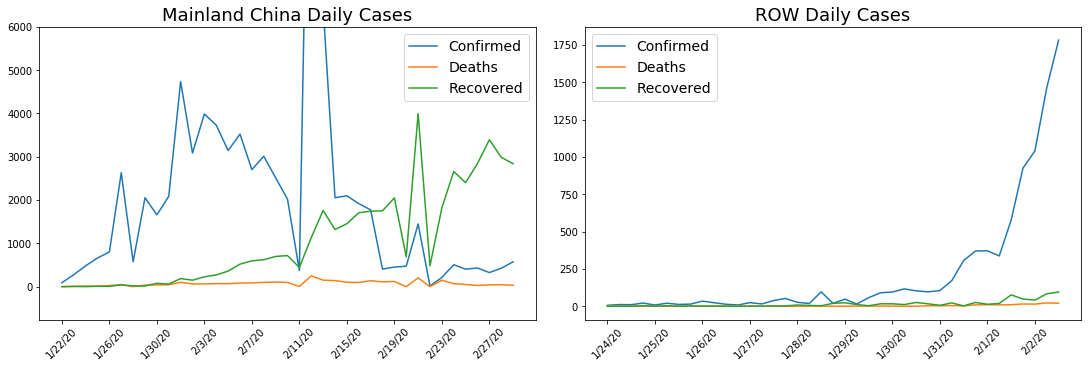

In [14]:
fig = plt.figure(figsize = (15, 5), constrained_layout=True)
gs = fig.add_gridspec(1,2)


# ax1 = fig.add_subplot(gs[0, 0])
# ax1.plot(np.transpose(total.to_numpy())[1:,:] - np.transpose(total.to_numpy())[:-1,:])
# myLocator = mticker.MultipleLocator(4)
# ax1.xaxis.set_major_locator(myLocator)
# ax1.set_ylim(top = 6000)
# ax1.tick_params(axis = 'x', labelrotation = 45)
# a = ax1.set_xticklabels(time_str[1:])
# ax1.legend(total.index, fontsize = 14)
# ax1.set_title('Total Daily Cases', size = 18)

ax2 = fig.add_subplot(gs[0, 0])
ax2.plot(np.transpose(mainland_china.to_numpy())[1:,:] - np.transpose(mainland_china.to_numpy())[:-1,:])
a = ax2.set_xticklabels(time_str[1:])
ax2.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
myLocator = mticker.MultipleLocator(4)
ax2.xaxis.set_major_locator(myLocator)
ax2.set_ylim(top = 6000)
ax2.tick_params(axis = 'x', labelrotation = 45)
ax2.legend(mainland_china.index, fontsize = 14)
ax2.set_title('Mainland China Daily Cases', size = 18)

ax3 = fig.add_subplot(gs[0, 1])
ax3.plot(np.transpose(others.to_numpy())[1:,:] - np.transpose(others.to_numpy())[:-1,:])
ax3.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
myLocator = mticker.MultipleLocator(4)
ax3.xaxis.set_major_locator(myLocator)
ax3.tick_params(axis = 'x', labelrotation = 45)
a = ax3.set_xticklabels(time_str[1:])
ax3.legend(others.index, fontsize = 14)
ax3.set_title('ROW Daily Cases', size = 18)

In [15]:
"""US"""

'US'

In [16]:
df_US = df_time_series.groupby(['Country/Region']).get_group(('US'))
df_Ca = pd.DataFrame()
df_DP = pd.DataFrame()
df_USmain = pd.DataFrame()
for i in df_US.index:
    if ('CA' in df_US.loc[i, 'Province/State']):
        if('(From Diamond Princess)' not in df_US.loc[i, 'Province/State']) :
            df_Ca = df_Ca.append(df_US.loc[i,:])
    if('(From Diamond Princess)'in df_US.loc[i, 'Province/State']) :
        df_DP = df_DP.append(df_US.loc[i,:])
    else:
        df_USmain = df_USmain.append(df_US.loc[i,:])

Text(0.5, 1.0, 'Daily Cases')

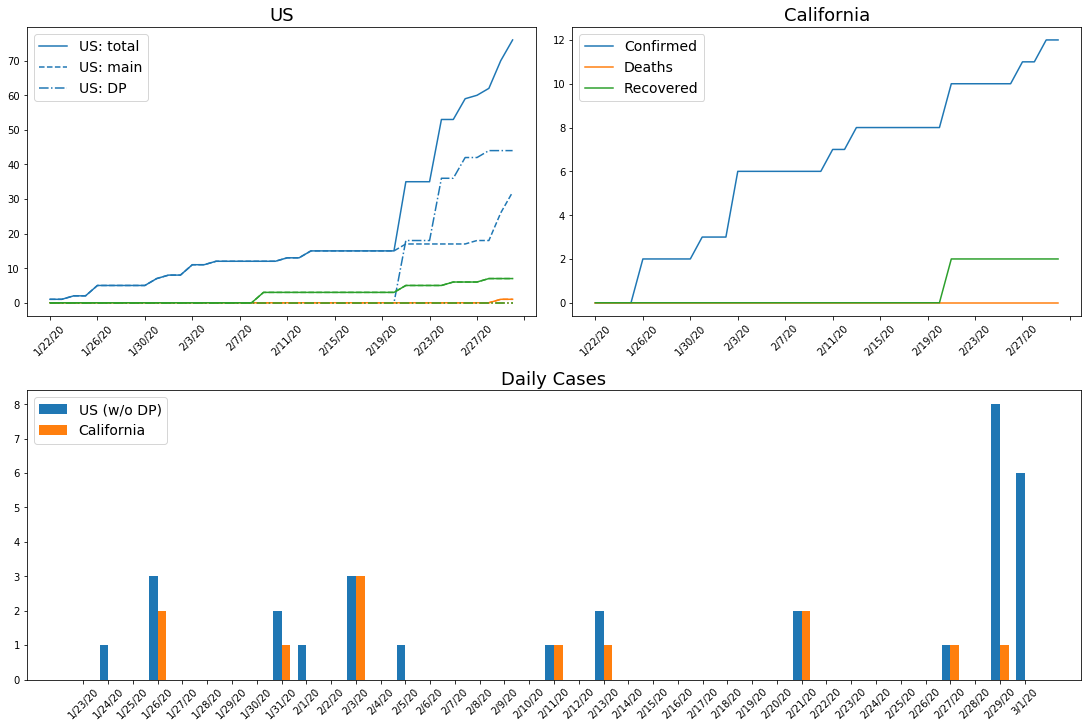

In [17]:
fig = plt.figure(figsize = (15, 10), constrained_layout=True)
gs = fig.add_gridspec(2,2)

ax1 = fig.add_subplot(gs[0, 0])
for cat in cat_color:
    ax1.plot(df_US.groupby('Category').get_group(cat).sum()[time_str], color = cat_color[cat])
    ax1.plot(df_USmain.groupby('Category').get_group(cat).sum()[time_str], '--', color = cat_color[cat])
    ax1.plot(df_DP.groupby('Category').get_group(cat).sum()[time_str], '-.', color = cat_color[cat])
legend = ['US: total', 'US: main', 'US: DP']
myLocator = mticker.MultipleLocator(4)
ax1.xaxis.set_major_locator(myLocator)
ax1.tick_params(axis = 'x', labelrotation = 45)
ax1.legend(legend, fontsize = 14)
ax1.set_title('US', size = 18)

ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(df_Ca.groupby('Category').sum().loc[:,time_str].transpose())
myLocator = mticker.MultipleLocator(4)
ax2.xaxis.set_major_locator(myLocator)
ax2.tick_params(axis = 'x', labelrotation = 45)
ax2.legend(others.index, fontsize = 14)
ax2.set_title('California', size = 18)

ax3 = fig.add_subplot(gs[1, :])
data1 = df_USmain.groupby('Category').get_group('Confirmed').sum()[time_str].to_numpy()[1:] - df_USmain.groupby('Category').get_group('Confirmed').sum()[time_str].to_numpy()[0:-1] 
data2 = df_Ca.groupby('Category').get_group('Confirmed').sum()[time_str].to_numpy()[1:] - df_Ca.groupby('Category').get_group('Confirmed').sum()[time_str].to_numpy()[0:-1] 
x = np.arange(len(data1))
width = 0.35
rects1 = ax3.bar(x - width/2, data1, width = width)
rects2 = ax3.bar(x + width/2, data2, width = width)
ax3.set_yscale('linear')
# ax3.set_yscale('linear')
# ax3.set_ylim([0, 1000])
a = ax3.set_xticks(x)
a = ax3.set_xticklabels(time_str[1:])
ax3.tick_params(axis = 'x', labelrotation = 45)
ax3.legend(['US (w/o DP)', 'California'], fontsize = 14)
ax3.set_title('Daily Cases', size = 18)

In [18]:
df_Ca.groupby('Category').get_group('Confirmed').loc[:,['Province/State', time_str[-1], 'New Today']]

,Province/State,3/1/20,New Today
297,"Orange, CA",1.0,0.0
298,"Los Angeles, CA",1.0,0.0
314,"Santa Clara, CA",3.0,0.0
318,"San Benito, CA",2.0,0.0
322,"San Diego County, CA",2.0,0.0
331,"Humboldt County, CA",1.0,0.0
332,"Sacramento County, CA",2.0,0.0


In [19]:
""" Mainland China """

' Mainland China '

In [20]:
mainland_china_group = df_time_series.groupby('Country/Region').get_group('Mainland China')
total_china = df_time_series.groupby('Country/Region').get_group('Mainland China').groupby('Category').sum().loc[:,time_str]
hubei = mainland_china_group.groupby('Province/State').get_group('Hubei').groupby('Category').sum().loc[:,time_str]
china_others = total_china - hubei

In [21]:
hubei.loc[:,time_str[-1]]

Category
Confirmed    66907
Deaths        2761
Recovered    31536
Name: 3/1/20, dtype: int64

Text(0.5, 1.0, 'Other Provinces Daily')

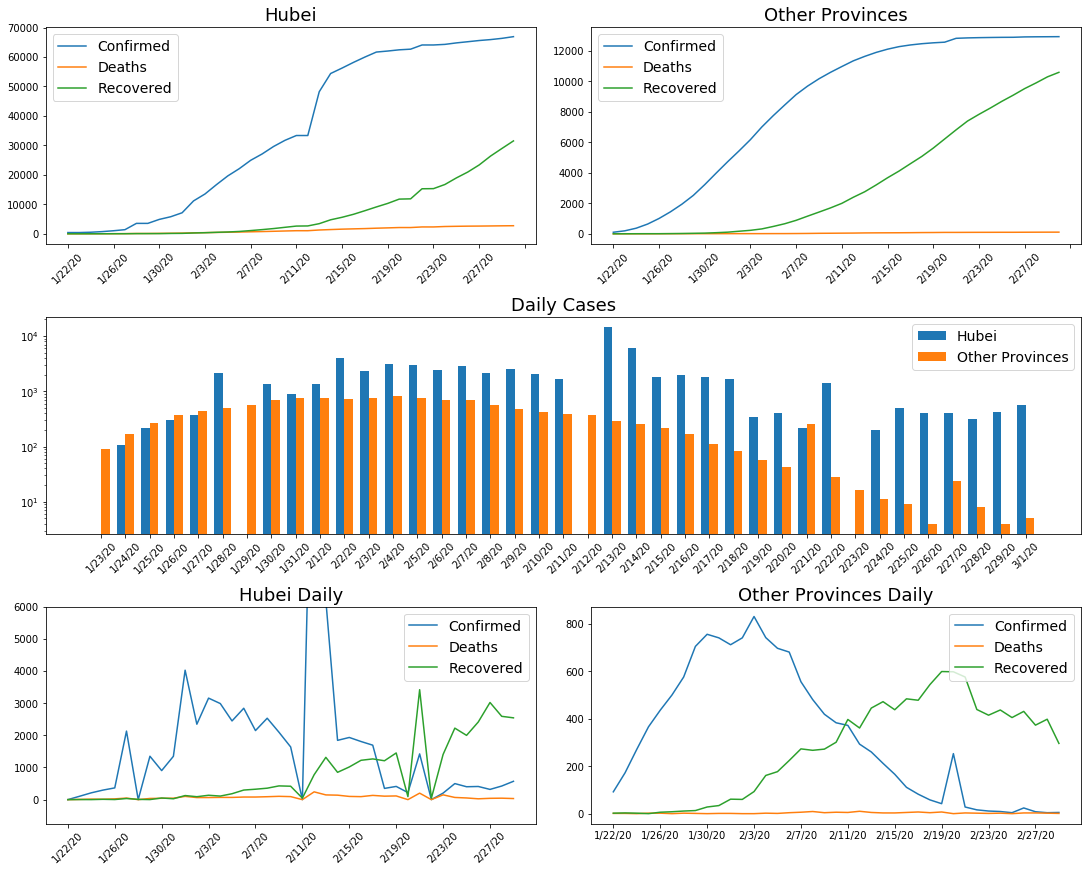

In [22]:
fig = plt.figure(figsize = (15, 12), constrained_layout=True)
gs = fig.add_gridspec(3,2)

ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(hubei.transpose())
myLocator = mticker.MultipleLocator(4)
ax1.xaxis.set_major_locator(myLocator)
ax1.tick_params(axis = 'x', labelrotation = 45)
ax1.legend(hubei.index, fontsize = 14)
ax1.set_title('Hubei', size = 18)

ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(china_others.transpose())
myLocator = mticker.MultipleLocator(4)
ax2.xaxis.set_major_locator(myLocator)
ax2.tick_params(axis = 'x', labelrotation = 45)
ax2.legend(others.index, fontsize = 14)
ax2.set_title('Other Provinces', size = 18)

ax3 = fig.add_subplot(gs[1, :])
data1 = hubei.loc['Confirmed',:].to_numpy()[1:] - hubei.loc['Confirmed',:].to_numpy()[:-1]
data2 = china_others.loc['Confirmed',:].to_numpy()[1:] - china_others.loc['Confirmed',:].to_numpy()[0:-1]
x = np.arange(len(data1))
width = 0.35
rects1 = ax3.bar(x - width/2, data1, width = width)
rects2 = ax3.bar(x + width/2, data2, width = width)
ax3.set_yscale('log')
# ax3.set_yscale('linear')
# ax3.set_ylim([0, 10])
a = ax3.set_xticks(x)
a = ax3.set_xticklabels(time_str[1:])
ax3.tick_params(axis = 'x', labelrotation = 45)
ax3.legend(['Hubei', 'Other Provinces'], fontsize = 14)
ax3.set_title('Daily Cases', size = 18)

ax4 = fig.add_subplot(gs[2, 0])
ax4.plot(np.transpose(hubei.to_numpy())[1:,:] - np.transpose(hubei.to_numpy())[:-1,:])
ax4.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
myLocator = mticker.MultipleLocator(4)
ax4.xaxis.set_major_locator(myLocator)
ax4.set_ylim(top = 6000)
ax4.tick_params(axis = 'x', labelrotation = 45)
ax4.legend(mainland_china.index, fontsize = 14)
ax4.set_title('Hubei Daily', size = 18)

ax5 = fig.add_subplot(gs[2, 1])
ax5.plot(np.transpose(china_others.to_numpy())[1:,:] - np.transpose(china_others.to_numpy())[:-1,:])
ax5.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
myLocator = mticker.MultipleLocator(4)
ax5.xaxis.set_major_locator(myLocator)
ax4.tick_params(axis = 'x', labelrotation = 45)
ax5.legend(others.index, fontsize = 14)
ax5.set_title('Other Provinces Daily', size = 18)

In [23]:
""" Outside Mainland China"""

' Outside Mainland China'

In [24]:
df_current = df_time_series.groupby('Category').get_group('Confirmed').groupby('Country/Region').sum()

In [25]:
### total cases

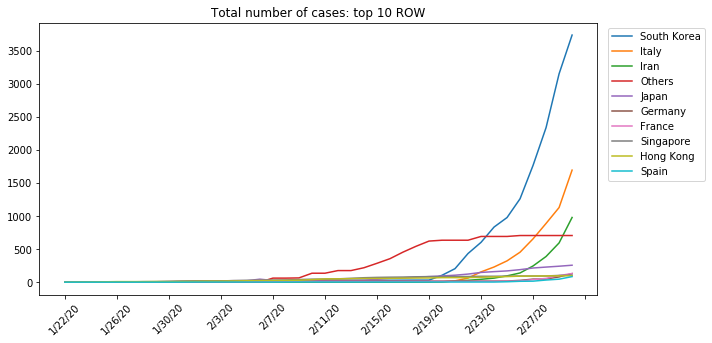

In [26]:
df_current.sort_values(by = time_str[-1], inplace = True, ascending=False)
countries = list(df_current.index[1:11])

df_plot = df_current.loc[countries,time_str]

fig, ax = plt.subplots(1,1,figsize = (10,5))
plt.plot(df_plot.transpose())
plt.legend(countries, bbox_to_anchor=(1.01, 1), loc='upper left', ncol=1)
plt.yscale('linear')
# plt.ylim(top = 1500)
plt.title('Total number of cases: top 10 ROW')
a = plt.xticks(rotation=45)
myLocator = mticker.MultipleLocator(4)
ax.xaxis.set_major_locator(myLocator)

In [27]:
### new cases

['South Korea', 'Mainland China', 'Italy', 'Iran', 'Germany', 'Spain', 'France', 'Japan', 'UK', 'Switzerland']


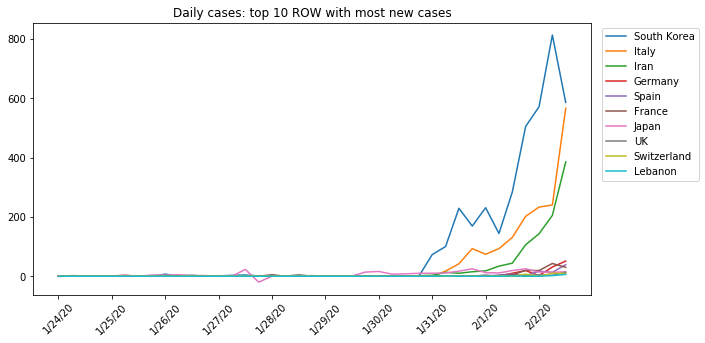

In [28]:
df_current.sort_values(by = 'New Today', inplace = True, ascending=False)
countries = list(df_current.index[0:10])
print(countries)
if('Mainland China' in countries):
    countries.remove('Mainland China')
    countries.append(df_current.index[11])
data = df_current.loc[countries,time_str].to_numpy().transpose()
fig, ax = plt.subplots(1,1,figsize = (10,5))
plt.plot(data[1:,:] - data[0:-1,:])
plt.legend(countries, bbox_to_anchor=(1.01, 1), loc='upper left', ncol=1)
plt.yscale('linear')
# plt.ylim(top = 200)
plt.title('Daily cases: top 10 ROW with most new cases')
a = plt.xticks(ticks = np.arange(len(time_str[1:])), labels = time_str[1:], rotation=45)
myLocator = mticker.MultipleLocator(4)
ax.xaxis.set_major_locator(myLocator)
ax.tick_params(axis = 'x', labelrotation = 45)


In [29]:
df_current.loc[countries,'New Today']

Country/Region
South Korea    586
Italy          566
Iran           385
Germany         51
Spain           39
France          30
Japan           15
UK              13
Switzerland      9
Lebanon          6
Name: New Today, dtype: int64

In [30]:
### world bar graph

In [31]:
df_confirmed = df_time_series.groupby('Category').get_group('Confirmed').groupby('Country/Region').sum()
df_recovered = df_time_series.groupby('Category').get_group('Recovered').groupby('Country/Region').sum()
df_deaths = df_time_series.groupby('Category').get_group('Deaths').groupby('Country/Region').sum()
df_confirmed.sort_values(by = time_str[-1], inplace = True, ascending=False)
df_recovered.sort_values(by = time_str[-1], inplace = True, ascending=False)
df_deaths.sort_values(by = time_str[-1], inplace = True, ascending=False)

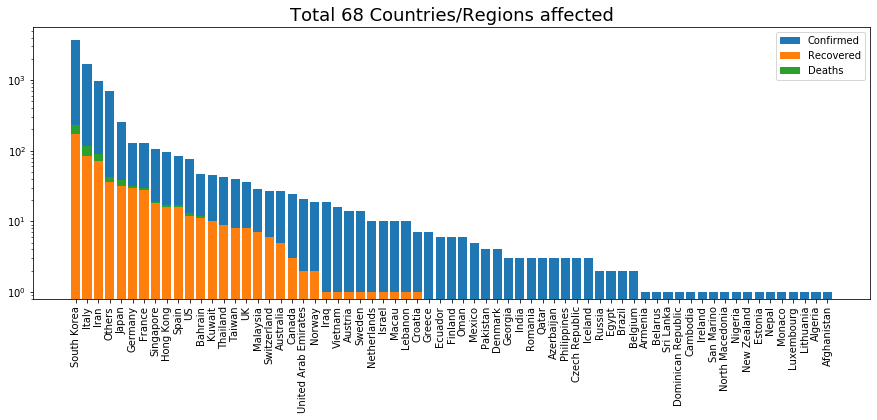

In [32]:
recovered = df_recovered.iloc[1:][time_str[-1]].to_numpy()
deaths = df_deaths.iloc[1:][time_str[-1]].to_numpy()
confirmed = df_confirmed.iloc[1:][time_str[-1]].to_numpy()
x = np.arange(len(confirmed))

fig, ax = plt.subplots(1,1,figsize = (15,5))
plt.bar(x, confirmed)
plt.bar(x, recovered)
plt.bar(x, deaths, bottom = recovered)

plt.legend(['Confirmed', 'Recovered', 'Deaths'])
plt.yscale('log')
plt.ylim(bottom = 10**-0.1)
a = ax.set_xticks(x)
a = ax.set_xticklabels(list(df_confirmed.index)[1:])
a = plt.xticks(rotation=90)
a = plt.title(f'Total {len(df_confirmed.index)} Countries/Regions affected', fontsize = 18)